# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
gpus = tf.config.experimental.list_physical_devices('GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

if gpus:
  try:
    # Restrict TensorFlow to only use the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

    # Limiting gpu memory growth
    tf.config.experimental.set_memory_growth(gpus[0], True)

  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


Using TensorFlow backend.


# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal. 
- We Use a personal computer with RTX 2070

Question 2: Google the name of the graphics card, how many CUDA cores does it have?
- It has 2304 Cuda Cores

Question 3: How much memory does the graphics card have?
- 8GB

Question 4: What is stored in the GPU memory while training a DNN ?
- Data of a given batch size, parameters, gradients...etc.

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.
- Intel i7-8750H with 6 Cores .. local machine

Question 6: How much CPU memory (RAM) is available in the cloud machine? Run 'free -g' in the terminal.
- 32GB .. local machine

# Part 4: Load the data

Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.




In [2]:
from numpy import genfromtxt
import numpy as np

# Load data from file
X = np.genfromtxt('Mirai_dataset.csv', delimiter=",")
Y = np.genfromtxt('Mirai_labels.csv', delimiter=",")
# X = covariates, Y = labels

# Save data as numpy arrays, for faster loading in future calls to this cell
np.save('Mirai_data.npy', X)
np.save('Mirai_labels.npy', Y)

# Load data from numpy arrays, for faster loading
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates
np.delete(X,np.s_[0:23], axis=1)

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
nClass, counts = np.unique(Y, return_counts=True)
print(dict(zip(nClass, counts)))

The covariates have size (764137, 116).
The labels have size (764137,).
{0.0: 121621, 1.0: 642516}


In [3]:
import numpy as np
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')
print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
nClass, counts = np.unique(Y, return_counts=True)
print(dict(zip(nClass, counts)))

The covariates have size (764137, 116).
The labels have size (764137,).
{0.0: 121621, 1.0: 642516}


# Part 5: How good is a naive classifier?

Question 7: Given the distribution of examples, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by random chance.

- Naive bayes assumption is that all features are independent. In this case wa have 116 features which are less likely to be
independent. So it seems that naive bayes will not provide us with a good result.

In [4]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
import numpy as np

# Print the number of NaNs (not a number) in the labels
print(np.nansum(Y))

# Print the number of NaNs in the covariates
print(np.nansum(X))

642516.0
4.483847529606055e+21


# Part 6: Preprocessing

Lets do some simple preprocessing

In [5]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to ints
Y = Y.astype(int)

# Remove mean of each covariate (column)
for col in range(116):
    X[:,col] = X[:, col] - np.mean(X[:,col])
#X = X - np.mean(X,axis=0)
# Divide each covariate (column) by its standard deviation
for col in range(116):
    X[:,col] = X[:, col] / np.std(X[:,col])

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(np.mean(X[:,20]))
print(np.std(X[:,20]))

4.2937354645120427e-16
1.0000000000000002


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)


In [6]:
# Your code
nRow = X.shape[0]
id = np.rint(0.7 * nRow)
id = id.astype(int)

Xtrain, Xtemp = X[:id,:], X[id:,:]
Ytrain, Ytemp = Y[:id], Y[id:]

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
print("The number of examples of each class in train set:")
classTrain, counts = np.unique(Ytrain, return_counts=True)
print(dict(zip(classTrain, counts)))

print("The number of examples of each class in temp set:")
classTemp, counts = np.unique(Ytemp, return_counts=True)
print(dict(zip(classTemp, counts)))


Xtrain has size (534896, 116).
Ytrain has size (534896,).
Xtemp has size (229241, 116).
Ytemp has size (229241,).
The number of examples of each class in train set:
{0: 121621, 1: 413275}
The number of examples of each class in temp set:
{1: 229241}


# Part 8: Number of examples per class

Question 8: Can we use the dataset as it is? Why not?
- No, If we split the dataset as it is, we won't have an appropriate proportion of both classes in our training data.. Mohsen
- Ussualy, it is better to do some data preprossing (It leds to better genirlization) before sending it to a model. Data preprocessing can be done using different techniques such as data splitting, data augmentation .. etc. Azhar
- It depends on the input data, if it is i.i.d. or not. It is better to shuffle it so we can treat it as i.i.d. .. Ahmed

Lets randomly shuffle the data, to get some examples of each class in training data and in the remaining 30%. Use the function `shuffle` in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

In [7]:
from sklearn.utils import shuffle

# Randomly shuffle data, to get both classes in training and testing
X, Y = shuffle(X, Y)

# Divide the data into training and validation/test again
id = np.floor(0.7 * nRow)
id = id.astype(int)

Xtrain, Xtemp = X[:id,:], X[id:,:]
Ytrain, Ytemp = Y[:id], Y[id:]

# Print the number of examples of each class, for the training data and the remaining 30%
print("The number of examples of each class in train set:")
classTrain, counts = np.unique(Ytrain, return_counts=True)
print(dict(zip(classTrain, counts)))

print("The number of examples of each class in temp set:")
classTemp, counts = np.unique(Ytemp, return_counts=True)
print(dict(zip(classTemp, counts)))


The number of examples of each class in train set:
{0: 85008, 1: 449887}
The number of examples of each class in temp set:
{0: 36613, 1: 192629}


#  Part 9: Split non-training data data into validation and test
Split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [8]:
from sklearn.model_selection import train_test_split

Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5)


print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 116), (114621, 116), (114621,) and (114621,)


# Part 10: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [9]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from keras.losses import binary_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01):

    # create sequential model
    model = keras.Sequential()
    model.add(keras.layers.Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    for i in range(n_layers - 1):
        model.add(keras.layers.Dense(n_nodes, activation=act_fun))
    model.add(keras.layers.Dense(1, activation=act_fun))
    
    # Setup optimizer, depending on input parameter string
    sgd = SGD(lr=learning_rate, momentum=0.8)

    # Compile model
    model.compile(optimizer=sgd,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
# Lets define a help function for plotting the training results

# IMPORTANT NOTE
# The history unfortunately behaves a bit randomly for every user
# If the plots for accuracy and loss look mixed, change the order of
# val_loss, val_acc, loss, acc
# until the plots look as they "should"

import matplotlib.pyplot as plt
def plot_results(history):
    val_loss, val_acc, loss, acc = history.history.values()

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 11: Train the DNN

Time to train the DNN, we start simple with 2 layers with 2 nodes each, learning rate 0.1.

### 2 layers, 20 nodes

In [11]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (116,)

# Build the model
model1 = build_DNN(input_shape=input_shape)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      validation_data = (Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 2s 3us/step - loss: 0.5946 - accuracy: 0.7964 - val_loss: 0.5156 - val_accuracy: 0.8403
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4830 - accuracy: 0.8411 - val_loss: 0.4601 - val_accuracy: 0.8403
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4471 - accuracy: 0.8411 - val_loss: 0.4380 - val_accuracy: 0.8403
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4305 - accuracy: 0.8411 - val_loss: 0.4256 - val_accuracy: 0.8403
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4200 - accuracy: 0.8411 - val_loss: 0.4165 - val_accuracy: 0.8403
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4115 - accuracy: 0.8411 - val_loss: 0.4087 - val_accuracy: 0.8403
Epoch 7/20
534895/534895 [==============================] - 

In [12]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 6s 53us/step
Test loss: 0.3119
Test accuracy: 0.8403


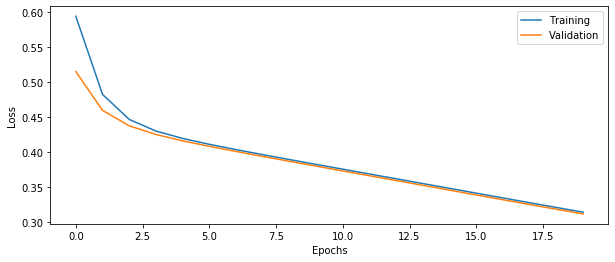

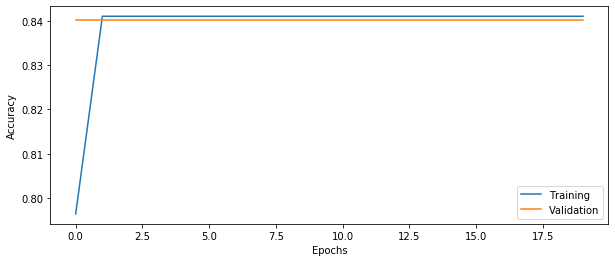

In [13]:
# Plot the history from the training run
plot_results(history1)

# Part 12: More questions

Question 9: What happens if you add several Dense layers without specifying the activation function?
- If we don't specify any activation function, no activation is applied. In other words, a linear function would be applied (a(x) = x).

Question 10: How are the weights in each dense layer initialized as default? How are the bias weights initialized?
- Weights are initialized with "Glorot uniform initializer" by default. It draws sample from a uniform distribution
within [-limit, limit] where limit is sqrt(6 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and
fan_out is the number of output units in the weight tensor.
Bias weights are initialized by "Zeroes". An Initializer that generates tensors initialized to 0.

# Part 13: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [14]:
from sklearn.utils import class_weight

# Calculate class weights
classWeight = class_weight.compute_class_weight(class_weight = 'balanced',
                                                classes = np.unique(Ytrain),
                                                y= Ytrain)
# Print the class weights
print(classWeight)

[3.14614507 0.59447706]


### 2 layers, 20 nodes, class weights

In [15]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (116,)

# Build and train model
model2 = build_DNN(input_shape=input_shape)

history2 = model2.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4414 - accuracy: 0.8411 - val_loss: 0.4385 - val_accuracy: 0.8403
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4332 - accuracy: 0.8411 - val_loss: 0.4306 - val_accuracy: 0.8403
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4256 - accuracy: 0.8411 - val_loss: 0.4230 - val_accuracy: 0.8403
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4182 - accuracy: 0.8411 - val_loss: 0.4158 - val_accuracy: 0.8403
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4111 - accuracy: 0.8411 - val_loss: 0.4088 - val_accuracy: 0.8403
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4042 - accuracy: 0.8411 - val_loss: 0.4020 - val_accuracy: 0.8403
Epoch 7/20
534895/534895 [==============================] - 

In [16]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 7s 62us/step
Test loss: 0.3128
Test accuracy: 0.8403


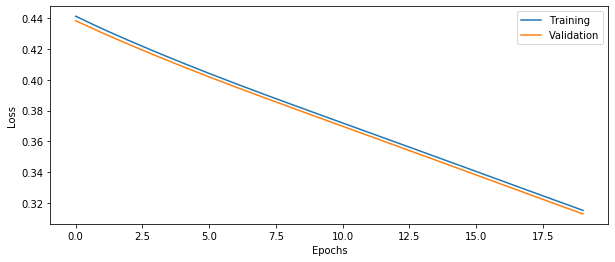

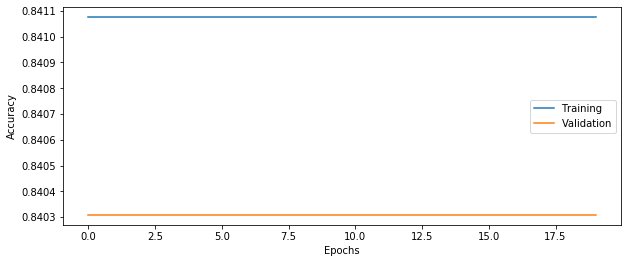

In [17]:
plot_results(history2)

# Part 14: More questions

Question 11: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.
- Using mini batchs means we train the network with smaller samples and this requier less memory, thus increasing the training performance. The machine memory may not fit the whole dataset, especially when we deal with big data. In addition, Using mini batchs means updating the weights more frequently which allows for a more robust convergence, avoiding local minima.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.
- The GPU is busy by about 15% when batch size = 100 and the memory usage increased from 161 MB to 429 MB. The 161MB is assumed to be used for windows background processes.

Question 13: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 
- 11-14 sec for batch size = 100, 2 sec for batch size = 1000 and less than 1 sec for batch size = 10000

Question 14: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  
- The weights are updated every iteration which = Number of Samples / Number ot Batches. This means when the batch size = 100 the weights are updated 5349 times, batch size = 1000 the weights updated 535 times and 54 times when the batch size = 10000.

Question 15: What limits how large the batch size can be?
- The batch size can be as large as the number of samples and can be limited by how much memory the GPU has

Question 16: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?
- General rule is “bigger batch size bigger learning rate”. Bigger batch size means more confidence in the direction of your “descent” of the error surface while the smaller a batch size is the closer you are to “stochastic” descent (batch size 1).

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 15: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 17: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()


### 4 layers, 20 nodes, class weights

In [18]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (116,)

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

model3.summary()

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.5050 - accuracy: 0.7899 - val_loss: 0.4392 - val_accuracy: 0.8403
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4379 - accuracy: 0.8411 - val_loss: 0.4391 - val_accuracy: 0.8403
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4377 - accuracy: 0.8411 - val_loss: 0.4390 - val_accuracy: 0.8403
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4376 - accuracy: 0.8411 - val_loss: 0.4388 - val_accuracy: 0.8403
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4374 - accuracy: 0.8411 - val_loss: 0.4386 - val_accuracy: 0.8403
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4373 - accuracy: 0.8411 - val_loss: 0.4384 - val_accuracy: 0.8403
Epoch 7/20
534895/534895 [==============================] - 

In [19]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 8s 67us/step
Test loss: 0.4294
Test accuracy: 0.8403


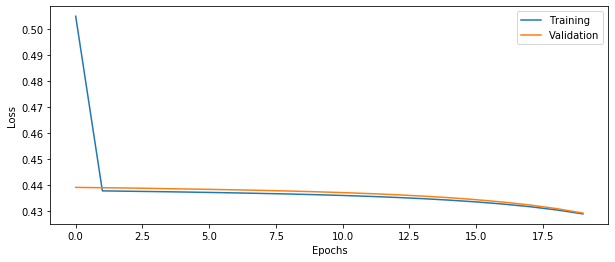

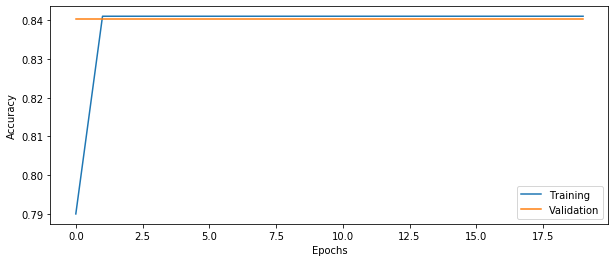

In [20]:
plot_results(history3)

## 2 layers, 50 nodes, class weights

In [21]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (116,)

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_nodes=50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

model4.summary()

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4318 - accuracy: 0.8411 - val_loss: 0.3802 - val_accuracy: 0.8403
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.3418 - accuracy: 0.8411 - val_loss: 0.3035 - val_accuracy: 0.8403
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.2705 - accuracy: 0.8412 - val_loss: 0.2424 - val_accuracy: 0.8448
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.2236 - accuracy: 0.8698 - val_loss: 0.2091 - val_accuracy: 0.9100
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1996 - accuracy: 0.9063 - val_loss: 0.1927 - val_accuracy: 0.9088
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1872 - accuracy: 0.9083 - val_loss: 0.1835 - val_accuracy: 0.9069
Epoch 7/20
534895/534895 [==============================] - 

### 2,781 Trainable Parameter

In [22]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 8s 66us/step
Test loss: 0.1059
Test accuracy: 0.9683


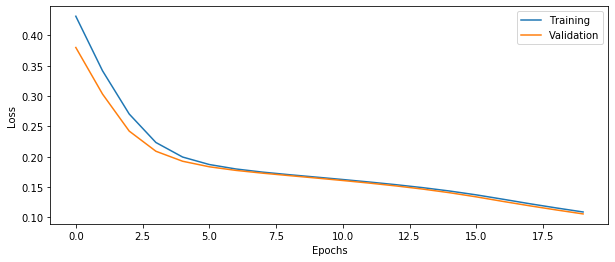

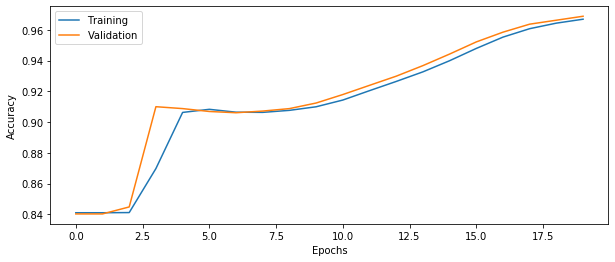

In [23]:
plot_results(history4)

## 4 layers, 50 nodes, class weights

In [24]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (116,)

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

model5.summary()

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4465 - accuracy: 0.8411 - val_loss: 0.4389 - val_accuracy: 0.8403
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4375 - accuracy: 0.8411 - val_loss: 0.4386 - val_accuracy: 0.8403
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4372 - accuracy: 0.8411 - val_loss: 0.4383 - val_accuracy: 0.8403
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4368 - accuracy: 0.8411 - val_loss: 0.4379 - val_accuracy: 0.8403
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4365 - accuracy: 0.8411 - val_loss: 0.4375 - val_accuracy: 0.8403
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.4361 - accuracy: 0.8411 - val_loss: 0.4371 - val_accuracy: 0.8403
Epoch 7/20
534895/534895 [==============================] - 

### 13,551 Trainable Paramters

In [25]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 8s 66us/step
Test loss: 0.3821
Test accuracy: 0.8403


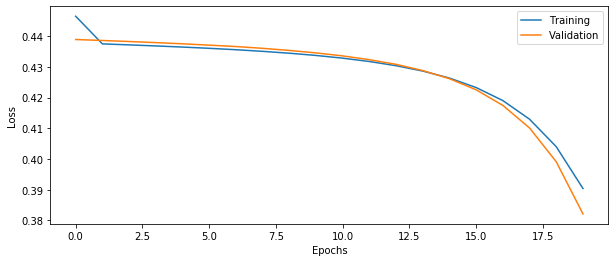

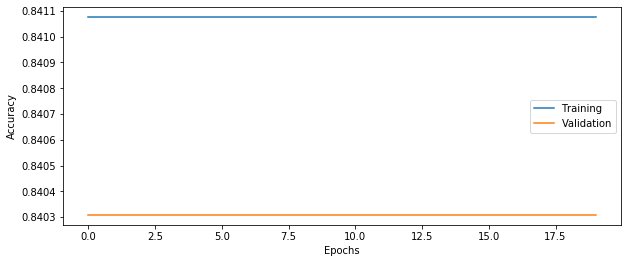

In [26]:
plot_results(history5)

# Part 16: Batch normalization

Now add batch normalization after each dense layer. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 18: Why is batch normalization important when training deep networks?
- When the data flows through the network each layer will update its input implementing the updated weights. As a result the distribution of the inputs may change which is called "Internal Covariate Shifting", thus the inputs for the next layer are no longer standardized. BatchNormalization is a thechnique in via which the input to each layer is normalized for each minibatch It stabilizes the learning process.

In [27]:
from keras.layers.normalization import BatchNormalization
# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN_Norm(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
              use_bn=True, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    sgd = SGD(lr=learning_rate)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun, input_dim = input_shape ))
    model.add(BatchNormalization())
    
    
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):        
        model.add(Dense(n_nodes, activation = act_fun))
        model.add(BatchNormalization())
                  
           
    
    
    # Final layer
    model.add(Dense(1, activation = act_fun))
    model.add(BatchNormalization())
    
    
    
    # Compile model
    model.compile(optimizer= sgd,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

## 2 layers, 20 nodes, class weights, batch normalization

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 116

# Build and train model
model6 = build_DNN_Norm(input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1, 
              use_bn=False, use_dropout=False, use_custom_dropout=False)

history6 = model6.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 2s 4us/step - loss: 0.6185 - accuracy: 0.8454 - val_loss: 2.4352 - val_accuracy: 0.1513
Epoch 2/20
534895/534895 [==============================] - 1s 3us/step - loss: 0.1831 - accuracy: 0.4581 - val_loss: 2.4352 - val_accuracy: 0.2042
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1767 - accuracy: 0.2726 - val_loss: 0.9947 - val_accuracy: 0.2061
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1569 - accuracy: 0.3192 - val_loss: 0.4807 - val_accuracy: 0.2074
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1013 - accuracy: 0.4253 - val_loss: 0.3956 - val_accuracy: 0.1799
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1056 - accuracy: 0.3574 - val_loss: 0.1586 - val_accuracy: 0.1882
Epoch 7/20
534895/534895 [==============================] - 

In [29]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 10s 90us/step
Test loss: 2.4358
Test accuracy: 0.4787


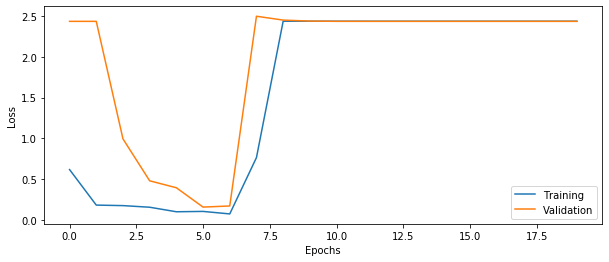

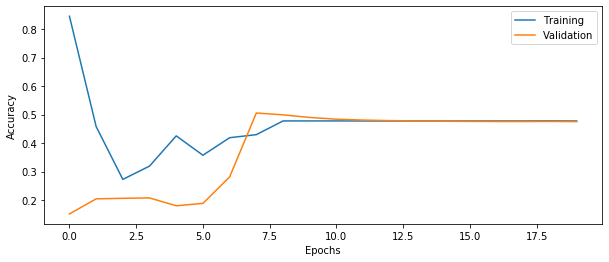

In [30]:
plot_results(history6)

# Part 17: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

In [31]:
from numpy.random import seed
seed(123)

def build_DNN_act(input_shape, n_layers, n_nodes, act_fun1='sigmoid',act_fun2='relu', optimizer='sgd', learning_rate=0.1, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    sgd = SGD(lr=learning_rate)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun2, input_dim = input_shape ))
    #model.add(BatchNormalization())
    
    
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):        
        model.add(Dense(n_nodes, activation = act_fun2))
        #model.add(BatchNormalization())
                  
           
    
    
    # Final layer
    model.add(Dense(1, activation = act_fun1))
    #model.add(BatchNormalization())
    
    
    
    # Compile model
    model.compile(optimizer= sgd,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

## 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [32]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 116

# Build and train model
model7 = build_DNN_act(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history7 = model7.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.2834 - accuracy: 0.8730 - val_loss: 0.1886 - val_accuracy: 0.8945
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1756 - accuracy: 0.9072 - val_loss: 0.1664 - val_accuracy: 0.9143
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1558 - accuracy: 0.9226 - val_loss: 0.1424 - val_accuracy: 0.9359
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1257 - accuracy: 0.9498 - val_loss: 0.1082 - val_accuracy: 0.9623
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0942 - accuracy: 0.9685 - val_loss: 0.0810 - val_accuracy: 0.9745
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0722 - accuracy: 0.9761 - val_loss: 0.0636 - val_accuracy: 0.9795
Epoch 7/20
534895/534895 [==============================] - 

In [33]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 7s 63us/step
Test loss: 0.0277
Test accuracy: 0.9894


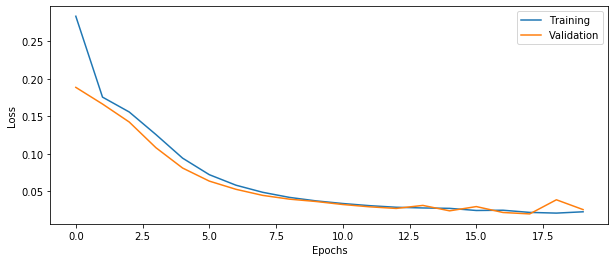

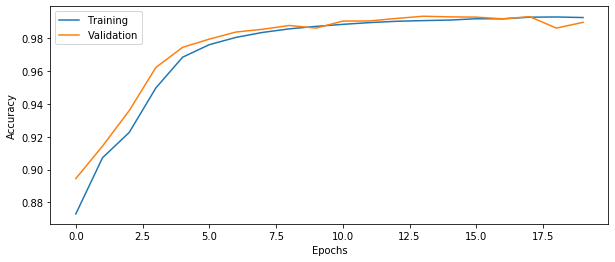

In [34]:
plot_results(history7)

# Part 18: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


In [35]:
from keras import optimizers
from numpy.random import seed
seed(123)

def build_DNN_opt(input_shape, n_layers, n_nodes, act_fun1='sigmoid',act_fun2='relu', optimizer='adam', learning_rate=0.1, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    optimizer = optimizers.Adam(learning_rate=0.1)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun1, input_dim = input_shape ))
    #model.add(BatchNormalization())
    
    
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):        
        model.add(Dense(n_nodes, activation = act_fun1))
        #model.add(BatchNormalization())
                  
           
    
    
    # Final layer
    model.add(Dense(1, activation = act_fun1))
    #model.add(BatchNormalization())
    
    
    
    # Compile model
    model.compile(optimizer= optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

## 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [36]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 116

# Build and train model
model8 = build_DNN_opt(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history8 = model8.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 3us/step - loss: 0.1825 - accuracy: 0.9014 - val_loss: 0.1275 - val_accuracy: 0.9474
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0541 - accuracy: 0.9795 - val_loss: 0.0298 - val_accuracy: 0.9877
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0288 - accuracy: 0.9892 - val_loss: 0.0247 - val_accuracy: 0.9904
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.0191 - val_accuracy: 0.9929
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0148 - accuracy: 0.9943 - val_loss: 0.0697 - val_accuracy: 0.9819
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0233 - accuracy: 0.9913 - val_loss: 0.0136 - val_accuracy: 0.9946
Epoch 7/20
534895/534895 [==============================] - 

In [37]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 8s 69us/step
Test loss: 0.0093
Test accuracy: 0.9970


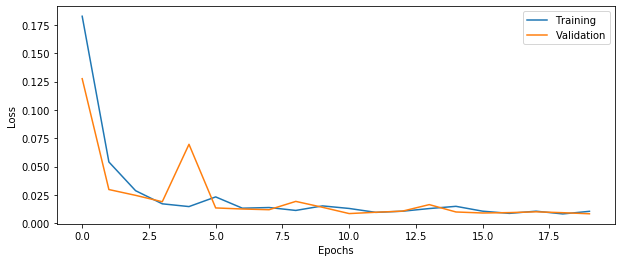

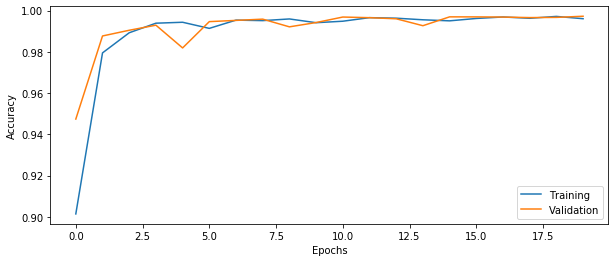

In [38]:
plot_results(history8)

# Part 19: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer), with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/layers/core/ for how the Dropout layer works.

---

Question 19: How does the validation accuracy change when adding dropout?

Question 20: How does the test accuracy change when adding dropout?
- Accuracy increases for both validation and test data compared to initial model.

In [39]:
from keras.layers import Dropout
from numpy.random import seed
seed(123)

def build_DNN_drp(input_shape, n_layers, n_nodes, act_fun1='sigmoid',act_fun2='relu', optimizer='adam', learning_rate=0.1, 
              use_bn=False, use_dropout=True, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    optimizer = optimizers.Adam(learning_rate=0.1)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun1, input_dim = input_shape ))
    model.add(Dropout(0.5))
    
    
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):        
        model.add(Dense(n_nodes, activation = act_fun1))
        model.add(Dropout(0.5))
                  
           
    
    
    # Final layer
    model.add(Dense(1, activation = act_fun1))
    
    
    
    
    # Compile model
    model.compile(optimizer= optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

## 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [40]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 116

# Build and train model
model9 = build_DNN_drp(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history9 = model9.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval))



Train on 534895 samples, validate on 114621 samples
Epoch 1/20
534895/534895 [==============================] - 1s 3us/step - loss: 0.2020 - accuracy: 0.8890 - val_loss: 0.1493 - val_accuracy: 0.9176
Epoch 2/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.1164 - accuracy: 0.9440 - val_loss: 0.0476 - val_accuracy: 0.9797
Epoch 3/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0702 - accuracy: 0.9751 - val_loss: 0.0323 - val_accuracy: 0.9892
Epoch 4/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0573 - accuracy: 0.9804 - val_loss: 0.0249 - val_accuracy: 0.9902
Epoch 5/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0483 - accuracy: 0.9831 - val_loss: 0.0272 - val_accuracy: 0.9873
Epoch 6/20
534895/534895 [==============================] - 1s 2us/step - loss: 0.0451 - accuracy: 0.9841 - val_loss: 0.0239 - val_accuracy: 0.9891
Epoch 7/20
534895/534895 [==============================] - 

In [41]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 8s 66us/step
Test loss: 0.0145
Test accuracy: 0.9947


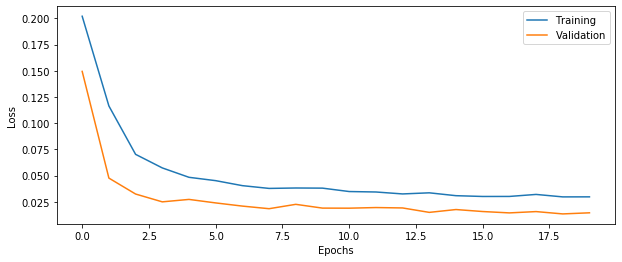

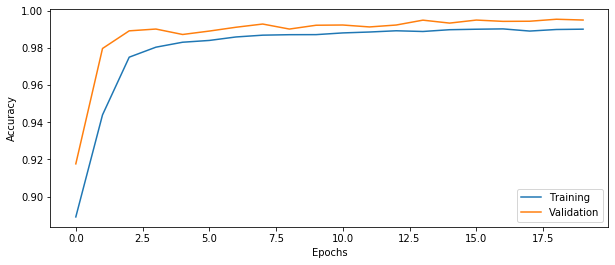

In [42]:
plot_results(history9)

# Part 20: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 21: How high classification accuracy can you achieve for the test data? What is your best configuration?
- Deepening the network to 10 layers increased the running time considerably, however no notable improvement in the performance was obtained. We got the best result with the following set:
- n_layers:3
- n_node/layer:40
- batch size: 8000
- epoch: 25
- Dropout probabbility: 0.5
- act_fun: relu
- optimizer:SGD

In [43]:
def build_DNN_cust(input_shape, n_layers, n_nodes, act_fun1='sigmoid',act_fun2='relu', optimizer='adam', learning_rate=0.1, 
              use_bn=False, use_dropout=True, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    optimizer = optimizers.SGD(learning_rate=0.1)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun2, input_dim = input_shape ))
    model.add(Dropout(0.5))
    
    
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):        
        model.add(Dense(n_nodes, activation = act_fun2))
        model.add(Dropout(0.5))
                  
           
    
    
    # Final layer
    model.add(Dense(1, activation = act_fun1))
    
    
    
    
    # Compile model
    model.compile(optimizer= optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [44]:
# Find your best configuration for the DNN
batch_size = 8000
epochs = 25
input_shape = 116
# Build and train DNN
model10 = build_DNN_cust(input_shape = input_shape, n_layers=3, n_nodes=40, learning_rate=0.1)

history10 = model10.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval)) 


Train on 534895 samples, validate on 114621 samples
Epoch 1/25
534895/534895 [==============================] - 1s 3us/step - loss: 0.3602 - accuracy: 0.8375 - val_loss: 0.1915 - val_accuracy: 0.8535
Epoch 2/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.2217 - accuracy: 0.8664 - val_loss: 0.1732 - val_accuracy: 0.9272
Epoch 3/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1952 - accuracy: 0.8919 - val_loss: 0.1607 - val_accuracy: 0.9375
Epoch 4/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1747 - accuracy: 0.9203 - val_loss: 0.1426 - val_accuracy: 0.9543
Epoch 5/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1551 - accuracy: 0.9389 - val_loss: 0.1219 - val_accuracy: 0.9657
Epoch 6/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1374 - accuracy: 0.9494 - val_loss: 0.1013 - val_accuracy: 0.9728
Epoch 7/25
534895/534895 [==============================] - 

In [45]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 9s 79us/step
Test loss: 0.0229
Test accuracy: 0.9929


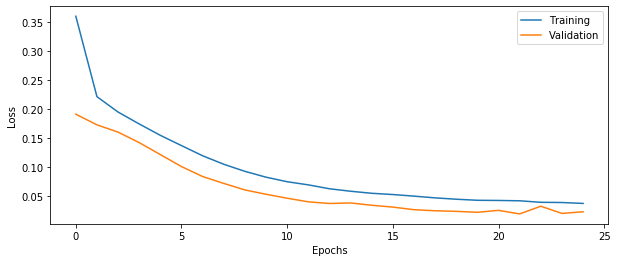

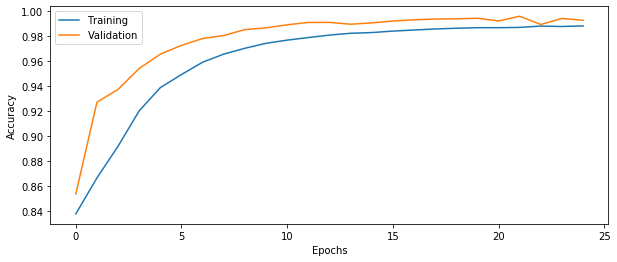

In [46]:
plot_results(history10)

# Part 21: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 22: What is the mean and the standard deviation of the test accuracy?

In [47]:
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [48]:
def build_DNN_custDrp(input_shape, noise_shape, n_layers, n_nodes, act_fun1='sigmoid',act_fun2='relu', optimizer='adam', learning_rate=0.1, 
              use_bn=False, use_dropout=True, use_custom_dropout=True):
    
    # Setup optimizer, depending on input parameter string
    optimizer = optimizers.SGD(learning_rate=0.1)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun2, input_dim = input_shape ))
    model.add(myDropout(rate=0.5, noise_shape=input_shape))
    
    
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):        
        model.add(Dense(n_nodes, activation = act_fun2))
        model.add(myDropout(rate=0.5, noise_shape=input_shape))                
           
    
    
    # Final layer
    model.add(Dense(1, activation = act_fun1))   
    
    
    
    # Compile model
    model.compile(optimizer= optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

### Your best config, custom dropout

In [49]:
# Your best training parameters
batch_size = 8000
epochs = 25
input_shape = 116
noise_shape = (batch_size, 116)
# Build and train model
model11 = build_DNN_custDrp(input_shape = input_shape, noise_shape=noise_shape, n_layers=3, n_nodes=40, learning_rate=0.1)

history11 = model11.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight,
                      validation_data = (Xval, Yval)) 

Train on 534895 samples, validate on 114621 samples
Epoch 1/25
534895/534895 [==============================] - 1s 3us/step - loss: 0.3430 - accuracy: 0.8491 - val_loss: 0.2464 - val_accuracy: 0.8649
Epoch 2/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.2297 - accuracy: 0.8716 - val_loss: 0.2151 - val_accuracy: 0.8780
Epoch 3/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.2036 - accuracy: 0.8848 - val_loss: 0.1961 - val_accuracy: 0.8898
Epoch 4/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1888 - accuracy: 0.8977 - val_loss: 0.1822 - val_accuracy: 0.9039
Epoch 5/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1752 - accuracy: 0.9131 - val_loss: 0.1711 - val_accuracy: 0.9205
Epoch 6/25
534895/534895 [==============================] - 1s 2us/step - loss: 0.1580 - accuracy: 0.9305 - val_loss: 0.1495 - val_accuracy: 0.9392
Epoch 7/25
534895/534895 [==============================] - 

In [50]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest)
                       
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 8s 74us/step
Test accuracy: 0.9890


In [51]:
# Run the testing 100 times, and save the accuracies in an array

    
# Calculate and print mean and std of accuracies



# Part 22: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 23: What is the mean and the standard deviation of the test accuracy?
- Mean: 0.9953293740749359 &  std: 0.0017479870616626569

Question 24: What is the main advantage of dropout compared to CV for estimating test uncertainty?
- Dropout is less computationaly expensive

In [52]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# Loop over cross validation folds
acc_cv = []
for train_index, test_index in skf.split(X, Y):    
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]
    # Calculate class weights for current split
    classWeight = class_weight.compute_class_weight(class_weight = 'balanced',
                                                classes = np.unique(Ytrain),
                                                y= Ytrain)
    # Rebuild the DNN model, to not continue training on the previously trained model
    batch_size = 8000
    epochs = 25
    input_shape = 116

    model_cv = build_DNN_cust(input_shape = input_shape, n_layers=3, n_nodes=40, learning_rate=0.1)
    # Fit the model with training set and class weights for this fold
    history_cv = model_cv.fit(Xtrain, Ytrain,
                      batch_size = batch_size,
                      epochs = epochs,
                      class_weight=classWeight)
    # Evaluate the model using the test set for this fold
    score = model_cv.evaluate(Xtest, Ytest)
    # Save the test accuracy in an array
    acc_cv.append(score[1])

# Calculate and print mean and std of accuracies
print("Mean:")
print(np.mean(acc_cv))

print("std:")
print(np.std(acc_cv))


=======] - 1s 2us/step - loss: 0.0391 - accuracy: 0.9884
Epoch 19/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.0373 - accuracy: 0.9890
Epoch 20/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.0355 - accuracy: 0.9897
Epoch 21/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.0354 - accuracy: 0.9900
Epoch 22/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.0333 - accuracy: 0.9905
Epoch 23/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.0321 - accuracy: 0.9909
Epoch 24/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.0322 - accuracy: 0.9908
Epoch 25/25
76414/76414 [==============================] - 6s 80us/step
Epoch 1/25
687723/687723 [==============================] - 2s 2us/step - loss: 0.3756 - accuracy: 0.8437
Epoch 2/25
687723/687723 [==============================] - 1s 2us/step - loss: 0.2250 - accuracy: 0.8848
Epoch 3/25
687723

# Part 23: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 25: How would you change the DNN in order to use it for regression instead?
- we have to change the loss function to mean_squared_error .. Mohsen *Correct
- We dont use activation function on the output layer .. Ahmed *Wrong

## Report

Send in this jupyter notebook, with answers to all questions.